In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

In [2]:
data = pd.read_csv('./survey_results_public.csv')

In [3]:
data.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [4]:
data.describe()

,Respondent,CompTotal,ConvertedComp,WorkWeekHrs,CodeRevHrs,Age
count,88883.000000,5.594500e+04,5.582300e+04,64503.000000,49790.000000,79210.000000
mean,44442.000000,5.519014e+11,1.271107e+05,42.127197,5.084308,30.336699
std,25658.456325,7.331926e+13,2.841523e+05,37.287610,5.513931,9.178390
min,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000
25%,22221.500000,2.000000e+04,2.577750e+04,40.000000,2.000000,24.000000
50%,44442.000000,6.200000e+04,5.728700e+04,40.000000,4.000000,29.000000
75%,66662.500000,1.200000e+05,1.000000e+05,44.750000,6.000000,35.000000
max,88883.000000,1.000000e+16,2.000000e+06,4850.000000,99.000000,99.000000


**Business and Data Understanding**

The data is from a survey organised by StackOverflow among its users(developers). The data contains fields like 
which country the developer belongs to, their salary, job satisfaction, career satisfaction, age, gender and many 
more. There could be possibly many insights that can be derived from this data. 

In this notebook, I've chosen to answer/analyse the following questions:
1. On an average, which age group of developers earn the most in the industry?
2. What is the trend in average salaries when compared across organisations of different sizes?
3. Do StartUps consist of significant percentage of senior developers or is it the youngsters that dominate? 
   Which country contributes to most developers working in start ups. 
4. How the the distribution among freelancers, when age group and country of residence is taken into account. 
5. Do majority of developers wish to work remotely? What factors do you think majorly influence this decision?

Note: Wherever Compensation come into picture, I've analysed it separately for different countries, as things like currency exchange rates play a role in the analysis.

In [5]:
def get_salary_vs_age_df(df, age_col, salary_col, country_col, currency_col, country, currency, threshold=0.01):
    """
    Returns a DataFrame with Age as index and AverageSalary as one of the columns.
    
    INPUTS:
    df      -- input dataframe
    age_col -- column name containing age of the respodent
    salary_col  -- column name containing salary of the respondent
    country_col -- column name contaning country the respondent bleongs to
    currency_col    -- column name contaning the currency symbol for the respondent's compensation
    country -- country name for which the data has to be calculated
    currency    -- only the passed in currency will be consider for the mean computation
    threshold   -- minimum number of responsdents required for the mean to be valid
    
    RETURNS:
    A dataframe with age as index and 2 columns, 'Count' and 'AverageSalary' 
    """
    # select only the required columns
    df = df[[age_col, salary_col, country_col, currency_col]]
    # filter respondents based on the country value and currency value
    df = df[(df[country_col] == country) & (df[currency_col] == currency)]
    # drop the country columns as it is not required anymore
    df = df.drop(columns=[country_col])
    # drop all rows with any nan value
    df = df.dropna(axis=0)
    # create a dataframe with index as age and count the number of respondents 
    # belonging to that age 
    df_sub = df.groupby(age_col).count()
    df.sort_values(age_col)
    df_sub = df_sub.rename(columns={salary_col: 'Count'})
    df_sub['AverageSalary'] = df.groupby(age_col).mean()
    tot_datapoints = df_sub.Count.sum()
    # filter rows based on minimum number of responses required
    df_sub = df_sub[df_sub.Count > threshold*tot_datapoints]
    return df_sub

In [6]:
def plot_data(title, xlabel, ylabel, fmt, df, figsize=(14, 5)):
    """
    Plots a line graph with the Dataframe's index on x-axis and AverageSalary on y-axis.
    
    INPUTS:
    title  -- title for the plot
    xlabel -- label for the x-axis
    ylabel -- label for the y-axis
    fmt -- format string which is eventually passed in to plot
    df  -- dataframe with an index and AverageSalary as one of it's column
    """
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.plot(np.arange(0, len(df.index), 1), df.AverageSalary/1000, fmt)
    ax.set_xticks(np.arange(0, len(df.index), 1))
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_xticklabels(df.index, rotation='30', fontsize=10, ha='right')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    plt.show()

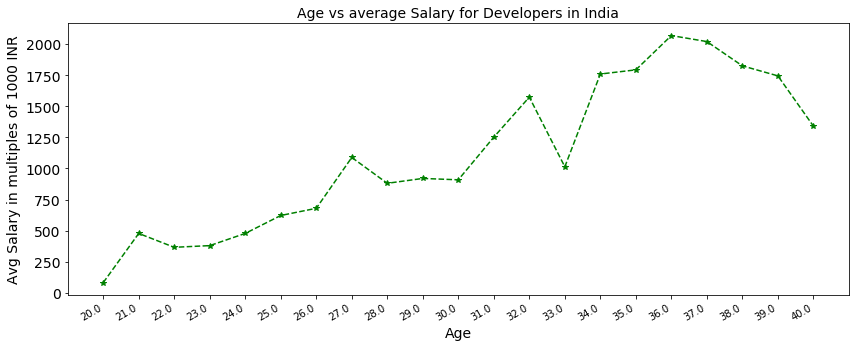

In [7]:
df_india = get_salary_vs_age_df(data, 'Age', 'CompTotal', 'Country', 'CurrencySymbol', 'India', 'INR', 0.005)
plot_data("Age vs average Salary for Developers in India", "Age", "Avg Salary in multiples of 1000 INR", \
          'g*--', df_india)

**Answer 1.1** : We see that in India, age groups 34-38 have the highest average salaries when compared to other age groups. The average pay in 20s' is very low when compared to late 30s'. 

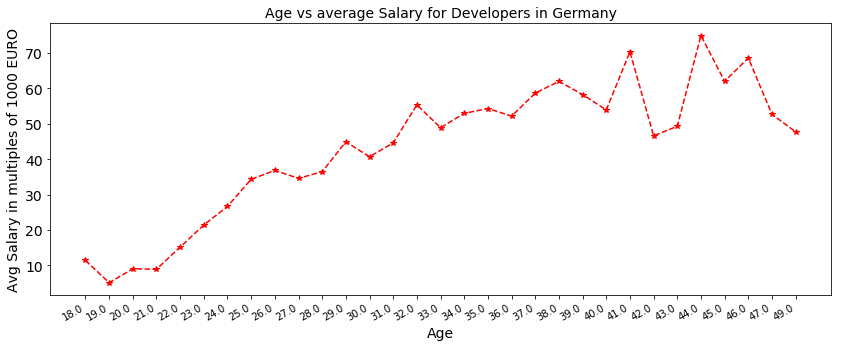

In [8]:
df_germany = get_salary_vs_age_df(data, 'Age', 'CompTotal', 'Country', 'CurrencySymbol', 'Germany', 'EUR', 0.005)
plot_data("Age vs average Salary for Developers in Germany", "Age", "Avg Salary in multiples of 1000 EURO", \
          'r*--', df_germany)

**Answer 1.2** : Whereas in Germany age group 40-46 seem to have the highest average salary, though there are a few discrepancies. Few people in their late 20s' seem to make similar to ones in their 40s'.

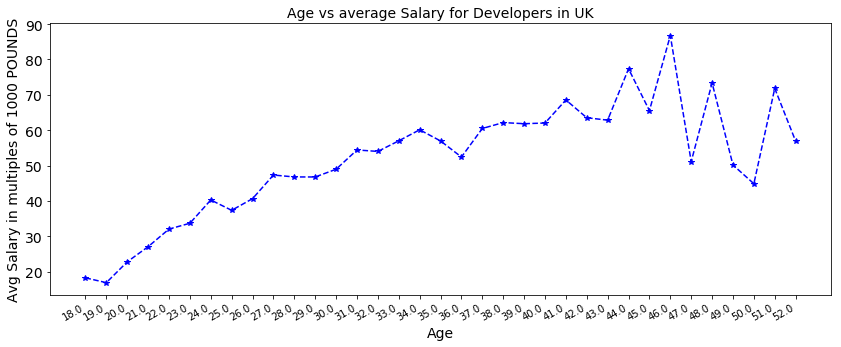

In [9]:
df_uk = get_salary_vs_age_df(data, 'Age', 'CompTotal', 'Country', 'CurrencySymbol' , 'United Kingdom', 'GBP', 0.005)
plot_data("Age vs average Salary for Developers in UK", "Age", "Avg Salary in multiples of 1000 POUNDS", \
          'b*--', df_uk)

**Answer 1.3** : In the UK too, ages 41-48 seem to make the most in the industry. Here too, similar to Germany, the average pay in early 30s' is almost equal to that of the 40s'.

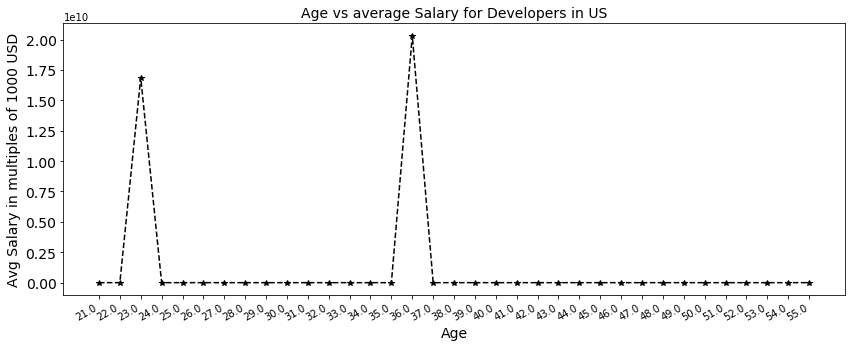

In [10]:
df_us = get_salary_vs_age_df(data, 'Age', 'CompTotal', 'Country', 'CurrencySymbol', 'United States', 'USD', 0.005)
plot_data("Age vs average Salary for Developers in US", "Age", "Avg Salary in multiples of 1000 USD", 'k*--', df_us)

**What do the spikes indicate?** The responses might correspond to individuals in higher rankings with companies in the Silicon Valley. So for own analysis, we can safely take them as outliers

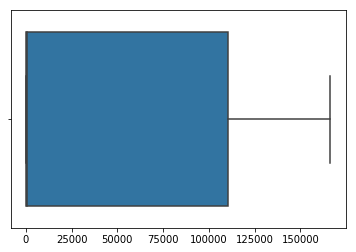

In [11]:
sns.boxplot(x=df_us[df_us.AverageSalary < 1e6])

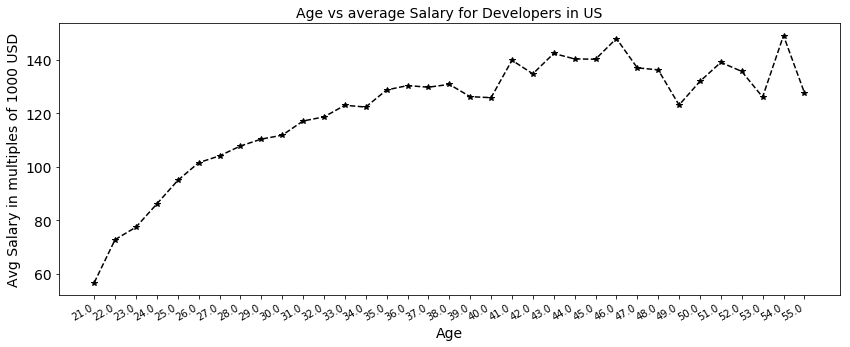

In [12]:
df_us_1 = get_salary_vs_age_df(data[data.CompTotal < 2*1e6], 'Age', 'CompTotal', 'Country', 'CurrencySymbol', \
                               'United States', 'USD', 0.005)
plot_data("Age vs average Salary for Developers in US", "Age", "Avg Salary in multiples of 1000 USD", 'k*--', df_us_1)

**Answer 1.4** : US seems to have a broad age spectrum of high average salaries, corresponding to ages 40-55. Here too the average salary of people in their late 30s' is equal to that of people in 40s'.

The trends among UK, US and Germany seem similar but the trend in India is a bit different. While in the former, people in their 40s' have the highest average, people in late 30s' have the highest average salary in the later case. Also, in India, there seems to be a significant pay gap among the young and senior developers, while that doesn't seem to exist in countries like US, UK & Germany.  

In [13]:
def get_salary_vs_orgsize_df(df, orgsize_col, salary_col, country_col, currency_col, country, currency, \
                             threshold=0.01):
    """
    Returns a DataFrame with OrgSize as index and AverageSalary as one of the columns.
    
    INPUTS:
    df      -- input dataframe
    orgsize_col -- column name containing the organisation size the respondent belongs to
    salary_col  -- column name containing salary of the respondent
    country_col -- column name contaning country the respondent bleongs to
    currency_col    -- column name contaning the currency symbol for the respondent's compensation
    country -- country name for which the data has to be calculated
    currency    -- only the passed in currency will be consider for the mean computation
    threshold   -- minimum number of responsdents required for the mean to be valid
    
    RETURNS:
    A dataframe with OrgSize as index and 2 columns, 'Count' and 'AverageSalary' 
    """
    # since the functionality is same as get_salary_vs_age_df, we can cal that function, with orgsize_col
    # inplace of age_col
    orgsizes = ["Just me - I am a freelancer, sole proprietor, etc.", "2-9 employees", "10 to 19 employees", \
                "20 to 99 employees", "100 to 499 employees", "500 to 999 employees", "1,000 to 4,999 employees", \
                "5,000 to 9,999 employees", "10,000 or more employees"]
    df['m_orgsize'] = pd.Categorical(df[orgsize_col], orgsizes)
    values_map = {
        "Just me - I am a freelancer, sole proprietor, etc.": "freelancer",
        "2-9 employees": "2-9",
        "10 to 19 employees": "10-19",
        "20 to 99 employees": "20-99",
        "100 to 499 employees": "100-499",
        "500 to 999 employees": "500-999",
        "1,000 to 4,999 employees": "1000-4999",
        "5,000 to 9,999 employees": "5000-9999",
        "10,000 or more employees": "10K+"
    } 
    df['m_orgsize'] = df['m_orgsize'].map(values_map)
    df = get_salary_vs_age_df(df, 'm_orgsize', salary_col, country_col, currency_col, country, currency, \
                              threshold=0.01)
    return df

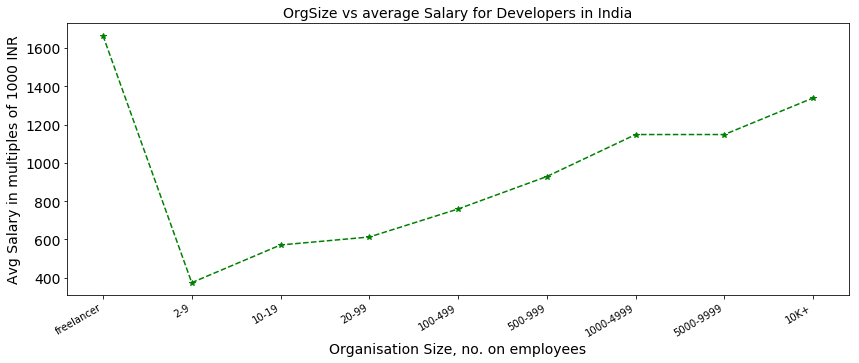

In [14]:
df_india = get_salary_vs_orgsize_df(data, 'OrgSize', 'CompTotal', 'Country', 'CurrencySymbol', 'India', 'INR', 0.005)
plot_data("OrgSize vs average Salary for Developers in India", "Organisation Size, no. on employees", "Avg Salary in multiples of 1000 INR", 'g*--', df_india)

**Answer 2.1** : We see that the mean salary for start ups(employee strength < 100) in India is a bit low when compared to other orgs and MNCs. Also we see that mean salary of freelancers is a bit more than those of MNCs. This might be due to the currency exchange value.   

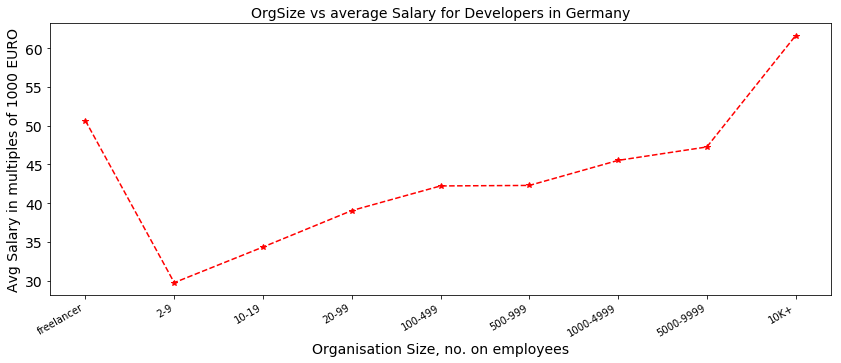

In [15]:
df_germany = get_salary_vs_orgsize_df(data, 'OrgSize', 'CompTotal', 'Country', 'CurrencySymbol', 'Germany', \
                                      'EUR', 0.005)
plot_data("OrgSize vs average Salary for Developers in Germany", "Organisation Size, no. on employees", "Avg Salary in multiples of 1000 EURO", 'r*--', df_germany)

**Answer 2.2** : Here too, the trend is similar to that of India, except in the case of freelancers. 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


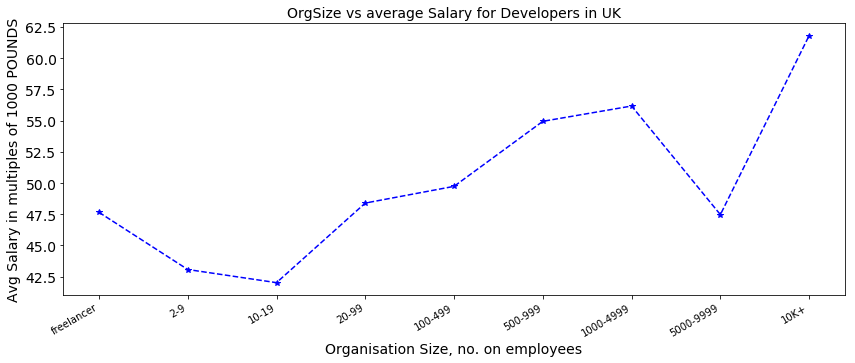

In [16]:
df_uk_1 = get_salary_vs_orgsize_df(data[data.CompTotal < 2*1e6], 'OrgSize', 'CompTotal', 'Country', \
                                   'CurrencySymbol', 'United Kingdom', 'GBP', 0.005)
plot_data("OrgSize vs average Salary for Developers in UK", "Organisation Size, no. on employees", "Avg Salary in multiples of 1000 POUNDS", 'b*--', df_uk_1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


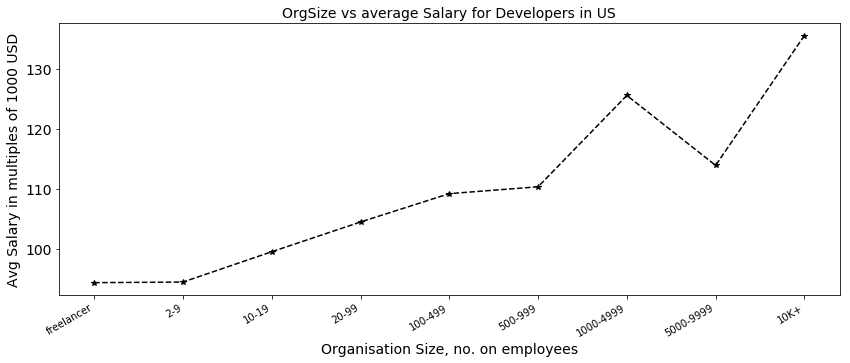

In [17]:
df_us_1 = get_salary_vs_orgsize_df(data[data.CompTotal < 2*1e6], 'OrgSize', 'CompTotal', 'Country', \
                                   'CurrencySymbol', 'United States', 'USD', 0.005)
plot_data("OrgSize vs average Salary for Developers in US", "Organisation Size, no. on employees", "Avg Salary in multiples of 1000 USD", 'k*--', df_us_1)

**Answer 2.3 & 2.4** : For US and UK too, the trends are similar to that of Germany, with an exception for freelancers. Freelancers of US and UK average the pay of startup in the countries. 

Thee trends in all 4 countries are quite similar with variation only in case of freelancers. Freelancers of India benefit the most due to conversion rate against the India Rupee.

**Data Preparation & Visualisation**

For answering question 3 & 4, below function help in preparing and visualising the data.

In [18]:
def get_org_dist_across_world(df, values):
    """
    Returns the distribution of respondents belonging to the specified org type, among the top 5 countries.
    
    INPUTS:
    df  -- The input DataFrame containing columns 'OrgSize', 'Respondent', 'Country'
    values  -- All possible values for the org size, that we need the distribution among the countries for 
    
    OUTPUTS:
    Two lists, first containing top 5 countries that contribute to the specified org type, the second 
    containing the precentages split among the 5 countries.
    """
    # filter only respondents that belong to the specified org type
    df['isOrg'] = df.OrgSize.apply(lambda x: True if x in values else False)
    df = df[df['isOrg']]
    df = df[['Respondent', 'Country']]
    # compute contribution of developers from each country
    df = df.groupby(['Country']).count().sort_values(by='Respondent', axis=0, ascending=False)
    df['Respondent'] = df['Respondent']*100/df['Respondent'].sum()
    return df.index[:5], df.Respondent[:5]

def get_age_dist_in_org(df, values):
    """
    Returns the age distribution in the specified org type.
    
    INPUTS:
    df  -- The input DataFrame containing columns 'OrgSize', 'Age'
    values  -- All possible values for the org size that we need age distribution in
    
    OUTPUTS:
    Two lists, first containing different age groups, and the second containing the precentages split among 
    the mentioned age groups.
    """
    # filter only respondents that belong to the specified org type
    df['isOrg'] = df.OrgSize.apply(lambda x: True if x in values else False)
    df = df[df['isOrg']]
    
    # for age less than 20
    col = 'Age_<_20'
    cols = [col]
    vals = []
    df[col] = df['Age'].apply(lambda x: 1 if x < 20 else 0)
    vals.append(df[col].sum()*100/len(df))
    
    # for ages [20, 25), [25, 30), ..., [45, 50)
    for i in range(20, 51, 5):
        col = 'Age_' + str(i) + '_' + str(i+5)
        cols.append(col)
        df[col] = df['Age'].apply(lambda x: 1 if x >= i and x < (i+5) else 0)
        vals.append(df[col].sum()*100/len(df))
    
    # for age >= 50
    col = 'Age_>=_50'
    cols.append(col)
    df[col] = df['Age'].apply(lambda x: 1 if x >= 50 else 0)
    vals.append(df[col].sum()*100/len(df))
    
    return cols, vals

def plot_stack_bar_graphs(dist_labels, dist_values, xlabels, title):
    """
    Plots a bar graph, comparing the given distribution across various labels
    
    INPUTS:
    dist_labels -- categories among which the distribution needs to be compared
    dist_values -- 2d list of shape (len(xlabels), len(dist_labels))
    xlabels -- list of fields in each of which the distribution will be plotted 
    title   -- title for the plot
    """
    bars = len(dist_values)
    width = 0.3
    k = 2*width/bars
    ind = np.arange(len(dist_values[0]))
    fig, ax = plt.subplots(figsize=(14, 7))
    fc = ['#2F4F4F','#FF7F50', '#00008B', '#DAA520', '#8B0000', '#5F9EA0', '#C71585', '#D2B48C', 'k']
    for i in range(bars):
        ax.bar(ind - width + i*k + width/bars, dist_values[i], k, label=xlabels[i], color=fc[i%len(fc)])
    ax.set_ylabel('Percentage', fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(ind)
    ax.set_xticklabels(dist_labels, fontsize=14)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    ax.legend()

def alter_list_of_lists(inp_list):
    """
    Returns the transpose of a 2d list
    """
    out_list = []
    for i in range(len(inp_list[0])):
        tmp = []
        for k in range(len(inp_list)):
            tmp.append(inp_list[k][i])
        out_list.append(tmp)
    return out_list

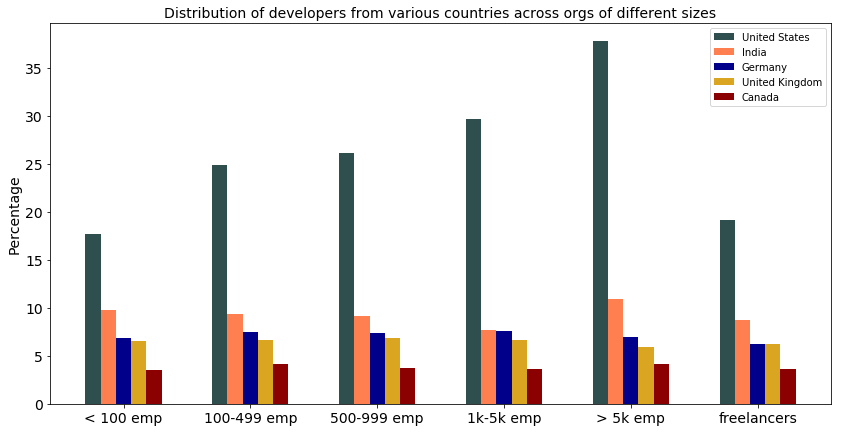

In [19]:
countries, startup_dist = get_org_dist_across_world(data, ["2-9 employees", "10 to 19 employees", \
                                                         "20 to 99 employees"])
_, less_500_dist = get_org_dist_across_world(data, ["100 to 499 employees"])
_, less_1000_dist = get_org_dist_across_world(data, ["500 to 999 employees"])
_, less_5k_dist = get_org_dist_across_world(data, ["1,000 to 4,999 employees"])
_, more_5k_dist = get_org_dist_across_world(data, ["5,000 to 9,999 employees", "10,000 or more employees"])
_, freelancers_dist = get_org_dist_across_world(data, ["Just me - I am a freelancer, sole proprietor, etc."])

country_wise_org_dist = [startup_dist, less_500_dist, less_1000_dist, less_5k_dist, more_5k_dist, freelancers_dist]
org_wise_country_dist = alter_list_of_lists(country_wise_org_dist)
plot_stack_bar_graphs(['< 100 emp', '100-499 emp', '500-999 emp', '1k-5k emp', '> 5k emp', 'freelancers'], \
                      org_wise_country_dist, countries, \
                      "Distribution of developers from various countries across orgs of different sizes")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

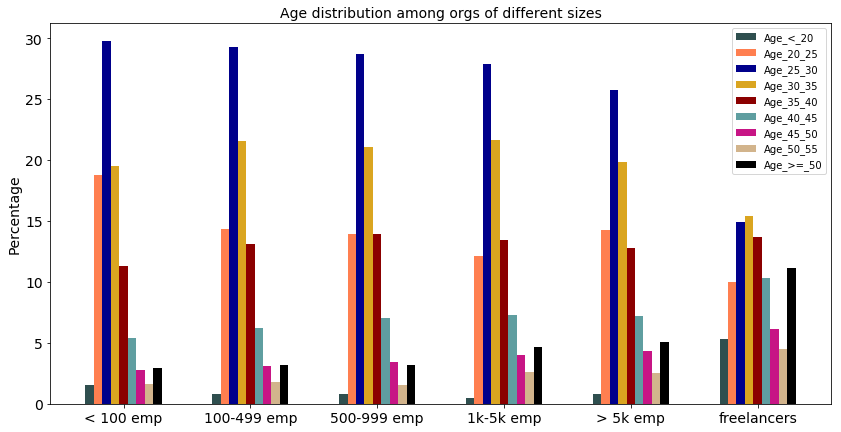

In [20]:
cols, startup_dist = get_age_dist_in_org(data, ["2-9 employees", "10 to 19 employees", "20 to 99 employees"])
_, less_500_dist = get_age_dist_in_org(data, ["100 to 499 employees"])
_, less_1000_dist = get_age_dist_in_org(data, ["500 to 999 employees"])
_, less_5k_dist = get_age_dist_in_org(data, ["1,000 to 4,999 employees"])
_, more_5k_dist = get_age_dist_in_org(data, ["5,000 to 9,999 employees", "10,000 or more employees"])
_, freelancers_dist = get_age_dist_in_org(data, ["Just me - I am a freelancer, sole proprietor, etc."])

age_wise_org_dist = [startup_dist, less_500_dist, less_1000_dist, less_5k_dist, more_5k_dist, freelancers_dist]
org_wise_age_dist = alter_list_of_lists(age_wise_org_dist)
plot_stack_bar_graphs(['< 100 emp', '100-499 emp', '500-999 emp', '1k-5k emp', '> 5k emp', 'freelancers'], \
                      org_wise_age_dist, cols, 'Age distribution among orgs of different sizes')

**Answer 3 & 4**

3. Do StartUps consist of significant percentage of senior developers or is it the youngsters that dominate? Which country contributes to most developers working in start ups.

Start ups'(< 100 employees) do seem to consist significant percentage of senior developers, though it might be a bit less in comparison to MNCs'. The percentage composition of age group 20-25 in start ups seems to be a bit more 
(5% increase) when compared with distribution among other orgs. So we can say that start ups consist of more percentage youngsters when compared to other orgs. 

As for contribution from different countries, USA seems to dominate in all org types. 



4. How the the distribution among freelancers, when age group and country of residence is taken into account.

When it comes to freelance, it has about 30-35% of people belonging to 40+ age. This seems to be pretty high when compared with the distribution across other org types, where it is somewhere between 10-20%. The young developers are under represented in this field in comparison to the MNCs. 

And similar to the earlier case, USA seems to dominate here too, but has significantly less contribution in comparison to the distribution in MNCs'.

**Data Preparation & Analysis for question 5**

To answer the last question, we will need to first convert the data into numbers, then analyse it. I've chosen a few fields which might possibly have an effect on the decision of 'working remotely'. 

In [21]:
# consider only full time employees 
df = data[data.Employment == "Employed full-time"]

In [22]:
# choose a subset of columns which might have an impact on this decision. 
df = df[['Hobbyist', 'OpenSourcer', 'OpenSource', 'Country', 'OrgSize', 'DevType', 'YearsCode', 'YearsCodePro',\
        'CareerSat', 'JobSat', 'WorkWeekHrs', 'WorkPlan', 'WorkLoc', \
        'WorkChallenge', 'WorkRemote', 'ImpSyn', 'CodeRev', 'Age', 'Gender']]

In [23]:
# drop rows which hace nan in age and gender fields
drop_na_in_cols = ['Age', 'Gender']
for col in drop_na_in_cols:
    df = df[~df[col].isna()]

In [24]:
def get_all_types(df, col):
    """
    Returns a dictionary of all possible fields for the given column.
    
    INPUTS:
    df  -- input DataFrame
    col -- column for which a cell might contain multiple values seperate by ';'
    
    RETURNS:
    A dictionary of all possible values 
    """
    type_dict = {}
    for ind in range(len(df)):
        try:
            val_types = df.iloc[ind][col].split(';')
            for val in val_types:
                if val != "" and val not in type_dict:
                    type_dict[val] = len(type_dict)
        except:
            continue
    return type_dict

def years_of_code(x):
    """
    Converts the cell value in YearsCode to appropriate integer.
    """
    try:
        x = int(x)
        return x
    except:
        if x == 'Less than 1 year':
            return 0
    return 51

def age_1st_code(x):
    """
    Converts the cell value in Age1stCode to appropriate integer.
    """
    try:
        x = int(x)
        return x
    except:
        if x == 'Younger than 5 years':
            return 4
    return 86

In [25]:
df['YearsCode'] = df.YearsCode.map(years_of_code)
df['YearsCodePro'] = df.YearsCodePro.map(years_of_code)

In [26]:
cols_with_mult_vals = ['DevType', 'WorkChallenge']

def one_hot_enc_fn(cell_val, val):
    """
    Returns 1 if given val is present in the cell
    """
    if val in cell_val:
        return 1
    return 0

# for columns with multiple vals, each possible value should be added as a new column.
# we call get_all_types(), which returns a dict of all possible values, then add a column for each value.
# for a given row, we set the newly added column to 1 if the value was present in the row's cell.
# Also we store a mapping from the converted col names to the value it represented.
col_map_dict = {}
for col in cols_with_mult_vals:
    df[col] = df[col].fillna("")
    val_types = get_all_types(df, col)
    for key, val in val_types.items():
        df[col + "_" + str(val)] = df[col].apply(lambda x: one_hot_enc_fn(x, key))
        col_map_dict[col + "_" + str(val)] = key
    print("converted col {}".format(col))

df = df.drop(columns=cols_with_mult_vals)

converted col DevType
converted col WorkChallenge


In [27]:
# for col WorkWeekHrs, fill the missing vals with the mean of the col
df['WorkWeekHrs'] = df['WorkWeekHrs'].fillna(df['WorkWeekHrs'].mean())

In [28]:
# for the remaining categorical columns containing single value, we use pd.get_dummies() to get one-hot 
# encoding, and then remove the original column.
category_cols = ['OpenSource', 'OrgSize', 'JobSat', 'WorkPlan', 'WorkRemote', 'ImpSyn', 'CodeRev', 'WorkLoc', \
                'Hobbyist', 'OpenSourcer', 'Country', 'CareerSat', 'Gender']
for col in category_cols:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col)], axis=1)

In [29]:
# convert all cols to float, see if any of the data is still in other forms and throws an exception
for col in df.columns:
    try:
        df[col] = df[col].apply('float64')
    except:
        print(col)

In [30]:
# calculate correlation of WorkLoc_Home with each column, and print the top positive and negative factors
cor_vals = []
for col in df.columns:
    cor_vals.append((df.WorkLoc_Home.corr(df[col]), col))
cor_vals.sort(key=lambda x: x[0], reverse=True)

[print(cor_vals[i]) for i in range(10)]
print("\n")
[print(cor_vals[i]) for i in range(len(cor_vals) - 10, len(cor_vals), 1)]
print("\n")

(0.9999999999999999, 'WorkLoc_Home')
(0.29146821122643085, "WorkRemote_All or almost all the time (I'm full-time remote)")
(0.12040091823492252, 'WorkRemote_More than half, but not all, the time')
(0.0962635113681041, 'Age')
(0.08533963322744184, 'WorkChallenge_7')
(0.0829131809005252, 'YearsCode')
(0.08138268662188074, 'WorkRemote_Less than half the time, but at least one day each week')
(0.07744682428438589, 'Country_United States')
(0.07613884146651002, 'WorkRemote_About half the time')
(0.059329776484028915, 'JobSat_Slightly dissatisfied')


(-0.026691455289114516, 'Country_Denmark')
(-0.027923128546240236, 'JobSat_Very satisfied')
(-0.02847615437362811, 'OpenSourcer_Never')
(-0.03435232193694178, 'Hobbyist_No')
(-0.04042615397594146, 'DevType_17')
(-0.04721252840480477, 'Country_India')
(-0.071441972403965, 'WorkRemote_A few days each month')
(-0.14736848792555773, 'WorkRemote_Less than once per month / Never')
(-0.18631909188263315, 'WorkLoc_Other place, such as a coworking space

In [31]:
# see what WorkChallenge_7 actually was 
print(col_map_dict['WorkChallenge_7']) 
print(col_map_dict['DevType_17'])

Time spent commuting
Student


In [32]:
# Of thetotal respondents, what percentage of employees actually wish to work remotely
data.WorkLoc.value_counts()/len(data)

Office                                            0.456690
Home                                              0.261895
Other place, such as a coworking space or cafe    0.069586
Name: WorkLoc, dtype: float64

In [33]:
data.WorkLoc.isna().sum()/len(data)

0.21182903367348085

**Answer 5** : Out of the total respondents, 46% chose office, 26% chose home, 7% preferred some othe co-working place when asked for about their preference for work location. The remaining 21% left the question unanswered.

On analysing the top factors which have a positive correlation with preference of working remotely, we saw that the below factors play a major role
1. People who currently work remotely all the time
2. Developers with more years of coding experience 
3. Developers who face challenge of long commuting hours
4. Developers who reside in USA
5. Developers who are slightly dissatisfied with their jobs

The top negative factors were:
1. Developers residing in India.
2. Developers who are currently enrolled as students too.
3. Developers who don't code as a hobby
4. Developers who have never contributed to open source 
5. Developers who are very much satisfied with their jobs
6. Developers residing in Denmark.